In [17]:
import pandas as pd
import os
import numpy as np 
from stable_baselines3.common.logger import configure
import matplotlib.pyplot as plt

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

%matplotlib inline


In [13]:
import torch

torch.cuda.is_available()

True

In [12]:
check_and_make_directories([TRAINED_MODEL_DIR])

In [21]:
train = pd.read_csv('prepared_csv/dow30_train_data.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']



In [4]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()



Stock Dimension: 29, State Space: 291


# Agents

In [14]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [8]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)


tmp_path = os.path.join(RESULTS_DIR, 'ppo')
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to results/ppo


/mnt/shared/miniconda3/envs/ml/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [9]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=200_000)

------------------------------------
| time/              |             |
|    fps             | 709         |
|    iterations      | 1           |
|    time_elapsed    | 2           |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -0.35303792 |
|    reward_max      | 2.524561    |
|    reward_mean     | 0.048855837 |
|    reward_min      | -2.3559427  |
------------------------------------
day: 313, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 1215554.11
total_reward: 215554.11
total_cost: 75567.14
total_trades: 8177
Sharpe: 1.493
-----------------------------------------
| time/                   |             |
|    fps                  | 605         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016622944 |
|    clip_fraction        | 0.193       |
|    clip_range     

In [10]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo")

# Test

In [3]:
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3


trade = pd.read_csv('prepared_csv/dow30_trade_data.csv')

trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo", device='cpu')

In [4]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_trade_gym = StockTradingEnv(
    df = trade, 
    turbulence_threshold = 70,
    risk_indicator_col='vix', 
    **env_kwargs
)

Stock Dimension: 29, State Space: 291


In [6]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym
)

df_result_ppo = (
    df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
)

hit end!


# Baseline

In [19]:
def stock_returns_compute(stock_price, rows, columns):
    stock_return = np.zeros([rows-1, columns])
    for j in range(columns):
        for i in range(rows-1): 
            stock_return[i,j]=(
                (stock_price[i+1, j]-stock_price[i,j])/stock_price[i,j]
            )* 100 
      
    return stock_return


def process_df_for_mvo(df):
    return df.pivot(index="date", columns="tic", values="close")

In [23]:
stock_data = process_df_for_mvo(train)
trade_data = process_df_for_mvo(trade)

In [25]:
ar_stock_prices = np.asarray(stock_data)
[rows, cols] = ar_stock_prices.shape
ar_returns = stock_returns_compute(ar_stock_prices, rows, cols)

mean_returns = np.mean(ar_returns, axis = 0)
cov_returns = np.cov(ar_returns, rowvar=False)
 
np.set_printoptions(precision=3, suppress = True)

In [27]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(mean_returns, cov_returns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(len(cleaned_weights_mean))])




last_price = np.array([1/p for p in stock_data.tail(1).to_numpy()[0]])
initial_portfolio = np.multiply(mvo_weights, last_price)



Portfolio_Assets = trade_data @ initial_portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result





,Mean Var
date,
2024-08-01,9.907952e+05
2024-08-02,9.713542e+05
2024-08-05,9.481691e+05
2024-08-06,9.605923e+05
2024-08-07,9.536767e+05
...,...
2024-12-20,1.149099e+06
2024-12-23,1.141832e+06
2024-12-24,1.159822e+06


# Results

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

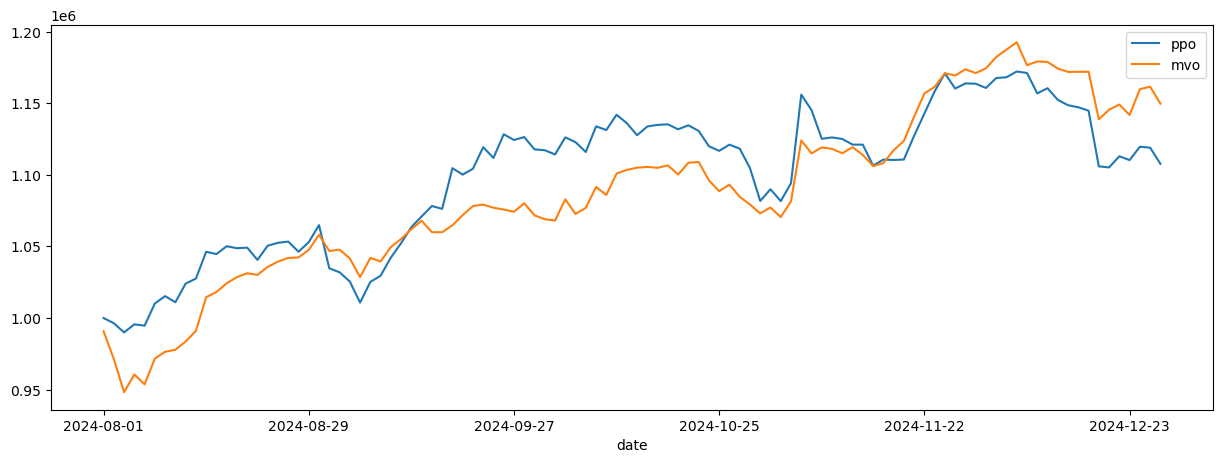

In [28]:
result = pd.DataFrame(
    {
        "ppo": df_result_ppo["account_value"],
        "mvo": MVO_result["Mean Var"],
    }
)

plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()